In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

sys.path.append('../../../do-mpc/')
import do_mpc

import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle

from casadi import *
from casadi.tools import *

sys.path.append('../../Surrogate_Model/DNN_woClustering/')
import keras2casadi

# Get NN model

In [3]:
model_name = '003'
model_path = '../../Surrogate_Model/DNN_woClustering/'

tf_model = tf.keras.models.load_model(model_path+'keras_models/{name}/{name}_model/'.format(name=model_name))

with open(model_path+'keras_models/{}/scaling.pkl'.format(model_name), 'rb') as f:
    scaling = pickle.load(f)

input_scaling = scaling['input']
output_scaling = scaling['output']

n_cluster = tf_model.get_layer('pressure_out').get_weights()[0].shape[0]

# Get demand sequence 


In [4]:
val_file_path = model_path+'validation/surrModel_scenarioDB_ruleBased_altControl2.pkl'
with open(val_file_path, 'rb') as f:
    validation = pickle.load(f)

In [5]:
input_names_raw = validation['input'].keys()
output_names_raw = validation['output'].keys()

input_names = {}
output_names = {}
input_names['demand'] = [name_i for name_i in input_names_raw if name_i.startswith('J')]
input_names['pumps'] = [name_i for name_i in input_names_raw if name_i.startswith('PU')]
input_names['valves'] = [name_i for name_i in input_names_raw if name_i.startswith('V')]
input_names['tanks'] = [name_i for name_i in input_names_raw if name_i.startswith('T')]

output_names['pressure'] = [name_i for name_i in output_names_raw if name_i.startswith('J')]
output_names['tanks'] = [name_i for name_i in output_names_raw if name_i.startswith('T')]
output_names['power'] = [name_i for name_i in output_names_raw if name_i.startswith('PU')]
    
val_demand = validation['input'][input_names['demand']]
val_states = validation['input'][input_names['tanks']]
val_inputs = validation['input'][input_names['pumps']+input_names['valves']]

val_pressure = validation['output'][output_names['pressure']]
val_energy = validation['output'][output_names['power']]

In [6]:
len(input_names['demand'])

388

## Cluster validation demand:

In [7]:
A,b = tf_model.get_layer('cluster_demand').get_weights()
val_demand_scaled = val_demand/input_scaling['demand'].to_numpy()
val_cluster_demand = (val_demand_scaled@A+b).to_numpy()

activation = tf_model.get_layer('cluster_demand').get_config()['activation']
if activation == 'linear':
    pass
else:
    raise Exception('unknown activation')

# Create do-mpc model

In [8]:
model = do_mpc.model.MXModel('discrete')

x = model.set_variable('_x',[
    entry('tank_level', shape=(7,1))
])
u = model.set_variable('_u',[
    entry('PU', shape=(len(input_names['pumps']),1)),
    entry('V', shape=(len(input_names['valves']),1))
])
tvp = model.set_variable('_tvp',[
    entry('cluster_demand', shape=(n_cluster,1))
    #entry('demand', shape=(388,1))
])

Evalute NN symbolically:

In [9]:
# All inputs to the NN must be in a dict with the names corresponding to inbound nodes in the keras model:
inputs_sym = {
    'cluster_demand': model.tvp['cluster_demand'].T,
    #'demand_in': model.tvp['demand'].T/input_scaling['demand'].to_numpy().reshape(1,-1),
    'states_in': model.x['tank_level'].T/input_scaling['states'].to_numpy().reshape(1,-1),
    'inputs_in': model.u.cat.T/input_scaling['inputs'].to_numpy().reshape(1,-1)
}
# Evaluate NN. All layer outputs are also in a dict:
outputs_sym = keras2casadi.eval_nn(tf_model, inputs_sym)

dstates = outputs_sym['dstates_out'].T*output_scaling['dstates'].to_numpy()
energy_out = outputs_sym['energy_out'].T*output_scaling['energy'].to_numpy()
pressure_out = outputs_sym['pressure_out'].T*output_scaling['pressure'].to_numpy()
pressure_cluster_out = outputs_sym['tf_op_layer_strided_slice_2'].T

model.set_rhs('tank_level', model.x['tank_level']+dstates)

# Store expressions for pressure and energy:
pressure = model.set_expression('pressure', pressure_out)
pressure_cluster = model.set_expression('pressure_cluster', pressure_cluster_out)
energy = model.set_expression('energy', energy_out)

model.setup()

# Create simulator

In [10]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 1.0)

sim_tvp = simulator.get_tvp_template()
def sim_tvp_fun(t_now):
    k = int(t_now)
    sim_tvp['cluster_demand'] = val_cluster_demand[k].T
    #sim_tvp['demand'] = val_demand.iloc[k].T
    return sim_tvp

simulator.set_tvp_fun(sim_tvp_fun)

simulator.setup()

In [11]:
simulator.x0 = val_states.iloc[0].to_numpy()

In [12]:
simulator.reset_history()
for k in range(val_inputs.shape[0]):
    u_k = val_inputs.iloc[k].to_numpy().reshape(-1,1)
    simulator.make_step(u_k)

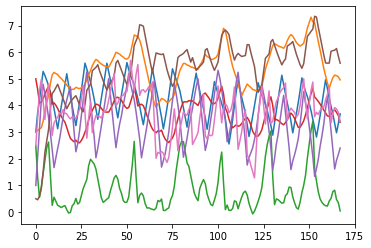

In [13]:
plt.plot(simulator.data['_x'])

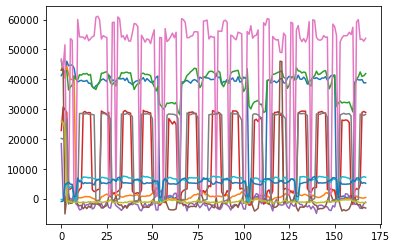

In [15]:
plt.plot(simulator.data['_aux','energy'])
plt.show()

# Create MPC

In [81]:
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
        'n_horizon': 5,
        'n_robust': 0,
        'open_loop': 0,
        't_step': 1.0,
        'store_full_solution': True,
        # Use MA27 linear solver in ipopt for faster calculations:
        'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
    }

mpc.set_param(**setup_mpc)

#lterm = sum1(model.aux['energy'])/1e4
lterm = sum1((model.x['tank_level']-5)**2)
mterm = sum1((model.x['tank_level']-5)**2)

mpc.set_objective(lterm = lterm, mterm=mterm)

mpc.set_rterm(PU=1e-4, V=1e-4)


#_ = mpc.set_nl_cons('pressure', -model.aux['pressure'], ub=0)
mpc.set_nl_cons('energy', -model.aux['energy'],ub=0, soft_constraint=True, penalty_term_cons=1e4)

#mpc.bounds['lower','_x','tank_level'] = 0
#mpc.bounds['upper','_x','tank_level'] = 7
mpc.bounds['lower','_u','PU'] = 0
mpc.bounds['upper','_u','PU'] = 1
mpc.bounds['lower','_u','V'] = 0
mpc.bounds['upper','_u','V'] = 1

mpc_tvp = mpc.get_tvp_template()

def mpc_tvp_fun(t_now):
    mpc_tvp['_tvp', :] = horzsplit(val_cluster_demand[int(t_now)+np.arange(mpc.n_horizon+1)].T)
    return mpc_tvp
    
mpc.set_tvp_fun(mpc_tvp_fun)

mpc.setup()

In [82]:
mpc.x0 = simulator.x0
mpc.u0 = np.ones((14,1))
mpc.set_initial_guess()

In [83]:
x0 = simulator.x0

u0 = mpc.make_step(x0)

This is Ipopt version 3.12.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     1757
Number of nonzeros in inequality constraint Jacobian.:     1210
Number of nonzeros in Lagrangian Hessian.............:     2478

Total number of variables............................:      293
                     variables with only lower bounds:       55
                variables with lower and upper bounds:       70
                     variables with only upper bounds:        0
Total number of equality constraints.................:      147
Total number of inequality constraints...............:       55
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       55

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.7192040e+03 5.22e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1

  82  2.5583987e+05 1.06e+02 7.88e+03  -1.0 4.54e+02   1.4 3.51e-03 2.40e-04h  1
  83  2.5762182e+05 1.00e+02 8.28e+03  -1.0 5.12e+02   0.9 2.71e-03 2.37e-03h  1
  84  2.5930064e+05 1.12e+02 2.78e+04  -1.0 4.46e+02   1.3 1.02e-02 2.29e-03h  1
  85  2.6111178e+05 1.57e+02 7.70e+04  -1.0 4.40e+02   1.7 1.04e-02 2.50e-03h  2
  86  2.6151119e+05 2.16e+02 7.41e+04  -1.0 1.06e+03   1.3 8.61e-03 5.67e-04h  3
  87  2.6292347e+05 2.85e+02 1.86e+05  -1.0 4.66e+02   1.7 3.10e-02 1.91e-03h  2
  88  2.6460086e+05 3.40e+02 1.91e+05  -1.0 4.65e+02   2.1 2.69e-03 2.26e-03h  1
  89  2.6499020e+05 3.54e+02 1.84e+05  -1.0 6.79e+02   1.6 5.22e-03 5.34e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.6501311e+05 3.54e+02 1.89e+05  -1.0 4.72e+02   2.1 9.70e-04 3.10e-05h  1
  91  2.6563491e+05 3.69e+02 1.89e+05  -1.0 6.40e+02   1.6 6.83e-04 8.57e-04h  2
  92  2.6562224e+05 3.71e+02 1.91e+05  -1.0 1.45e+04   1.1 1.20e-07 1.29e-05f  3
  93  2.6568556e+05 3.73e+02

 174r 3.8960223e+05 9.37e+01 9.97e+02   0.4 5.70e+02    -  1.08e-02 3.79e-03f  1
 175r 4.0123080e+05 5.28e+01 1.01e+03   0.4 5.86e+02    -  2.81e-02 1.17e-02f  1
 176r 4.2375161e+05 1.57e+02 1.00e+03   0.4 7.70e+02    -  2.59e-02 1.86e-02f  1
 177r 4.3838620e+05 2.37e+02 9.41e+02   0.4 3.42e+02    -  3.52e-02 2.26e-02f  1
 178r 5.0858752e+05 1.00e+03 9.27e+02   0.4 4.14e+02    -  1.27e-02 7.90e-02f  1
 179r 5.3394449e+05 8.59e+02 7.41e+02   0.4 9.32e+00   0.0 3.45e-01 1.49e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 5.5848687e+05 7.16e+02 6.72e+02   0.4 2.82e+00   1.3 2.17e-02 1.54e-01f  1
 181r 5.8231186e+05 4.93e+02 5.45e+02   0.4 1.30e+00   1.8 2.43e-01 2.80e-01f  1
 182r 5.8274619e+05 4.37e+02 1.68e+03   0.4 6.06e-01   3.1 2.23e-01 8.19e-02f  1
 183r 5.8599675e+05 2.62e+02 1.24e+03   0.4 6.36e-01   2.6 2.13e-01 2.26e-01f  1
 184r 5.8672992e+05 1.82e+02 2.11e+03   0.4 5.34e-01   3.0 2.35e-01 1.30e-01h  1
 185r 6.0189683e+05 2.19e+00

 272r 7.7968941e+05 2.18e+00 2.15e+01  -1.7 2.77e-02   2.6 7.01e-01 5.21e-02h  1
 273r 7.7960366e+05 2.17e+00 7.67e+00  -1.7 5.94e-02   2.1 1.00e+00 1.00e+00f  1
 274r 7.7935530e+05 2.17e+00 5.69e+00  -1.7 9.59e-02   1.6 1.00e+00 1.00e+00f  1
 275r 7.7863071e+05 2.17e+00 3.96e+00  -1.7 2.76e-01   1.2 1.00e+00 1.00e+00f  1
 276r 7.7691870e+05 2.17e+00 3.91e+00  -1.7 8.16e-01   0.7 1.00e+00 8.41e-01f  1
 277r 7.7194035e+05 2.16e+00 4.01e+00  -1.7 2.51e+00   0.2 8.36e-01 1.00e+00f  1
 278r 7.7156244e+05 2.16e+00 1.85e+01  -1.7 8.67e+00  -0.3 5.08e-01 5.39e-02f  1
 279r 7.7166175e+05 1.59e+01 1.99e+01  -1.7 3.88e+01  -0.8 3.24e-01 1.43e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 7.7062235e+05 1.88e+01 4.62e+01  -1.7 1.29e+01  -0.3 9.19e-01 2.05e-01f  1
 281r 7.6897817e+05 1.41e+01 3.57e+01  -1.7 4.66e+00   0.1 1.00e+00 5.39e-01f  1
 282r 7.6884853e+05 1.92e+01 7.17e+01  -1.7 6.09e+00  -0.4 1.63e-01 8.51e-02f  1
 283r 7.6916904e+05 1.97e+02

 365r 1.9291665e+06 1.40e+00 2.14e+01  -0.5 1.59e-01   2.0 1.00e+00 1.00e+00f  1
 366r 1.9299886e+06 1.40e+00 1.73e+02  -0.5 1.42e-01   1.5 1.00e+00 6.13e-01f  1
 367r 1.9466326e+06 3.71e+00 1.65e+02  -0.5 1.23e+02    -  2.90e-02 3.88e-02f  1
 368r 1.9978592e+06 9.75e+00 1.07e+02  -0.5 1.30e+01    -  3.63e-01 5.36e-01f  1
 369r 1.9995923e+06 1.39e+00 1.83e+00  -0.5 1.11e-01   1.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r 1.9818766e+06 1.39e+00 3.77e+00  -1.9 2.24e-01   0.6 6.82e-01 6.60e-01f  1
 371r 1.9695027e+06 1.38e+00 7.71e+01  -1.9 6.90e-01   0.1 5.66e-01 8.99e-01f  1
 372r 1.9448836e+06 8.79e+01 1.01e+02  -1.9 4.89e+00  -0.4 4.72e-01 7.91e-01f  1
 373r 1.9354360e+06 1.15e+02 7.59e+01  -1.9 1.41e+01  -0.9 2.07e-01 1.96e-01f  1
 374r 1.9322197e+06 1.65e+02 7.34e+01  -1.9 4.86e+01  -1.4 8.32e-02 8.89e-02f  1
 375  1.9310258e+06 1.65e+02 1.96e+02  -1.0 2.68e+02  -1.2 3.87e-03 2.32e-05f  1
 376  1.8566959e+06 1.66e+02

 458  1.4104478e+06 2.79e+02 3.36e+02  -1.0 8.30e+02 -20.0 3.64e-03 6.45e-05h  3
 459  1.4105082e+06 2.79e+02 7.18e+02  -1.0 8.20e+02 -20.0 3.76e-03 8.71e-05h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r 1.4105082e+06 2.79e+02 9.99e+02   0.1 0.00e+00 -20.0 0.00e+00 4.95e-07R 12
 461r 1.4109040e+06 1.99e+02 9.98e+02   0.1 6.04e+02    -  3.70e-03 1.33e-03f  1
 462r 1.4150227e+06 1.13e+02 9.93e+02   0.1 3.58e+02    -  3.26e-02 5.02e-03f  1
 463r 1.4312332e+06 1.46e+02 9.63e+02   0.1 1.47e+02    -  1.58e-02 2.97e-02f  1
 464r 1.4492980e+06 1.91e+02 9.18e+02   0.1 9.42e+01    -  1.30e-01 4.64e-02f  1
 465r 1.4968303e+06 2.35e+02 8.11e+02   0.1 6.52e+01    -  2.32e-01 1.17e-01f  1
 466r 1.6637764e+06 2.17e+02 4.55e+02   0.1 3.49e+01    -  7.23e-01 4.56e-01f  1
 467r 1.9131895e+06 7.75e+01 1.69e+02   0.1 5.79e+00    -  7.37e-01 6.38e-01f  1
 468r 2.0614224e+06 7.35e+00 2.37e+01   0.1 3.60e+00    -  1.00e+00 1.00e+00f  1
 469r 1.8525035e+06 1.15e+00

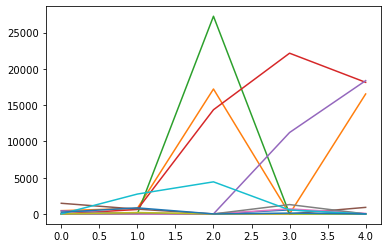

In [67]:
plt.plot(mpc.data.prediction(('_aux','energy'),-1).squeeze().T)

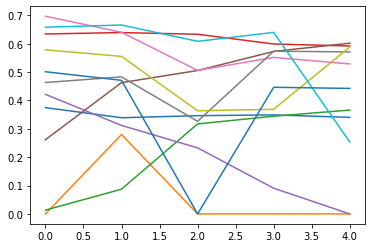

In [80]:
plt.plot(mpc.data.prediction(('_u','PU'),-1).squeeze().T)